# Preface

<br>**Title:** PDAC Untargeted Metabolomics and Gut Barrier Project
<br>**File Name:** DisVal_PDAC_Control
<br>**Updated on:** 14 August 2025
<br>**Author:** Chek, Zi Yan Jane
<br>**Supervised by:** Dr. David Hughes and Dr. Neil Daniel

<br>**Procedures Covered:**
- Model Training (Discovery–Validation Framework)
- Cross-Validation (CV)
- Model Evaluation
- Model Comparison

> **Note:** This script was developed by the author as part of a UCD academic research project under supervised guidance. The content is shared solely for evaluation, feedback, or academic review purposes. 
> Unauthorised distribution, reuse, or reproduction of the code or its components is not permitted without the author's written consent.

# Discovery–Validation Framework

## Import Libraries

In [80]:
import pandas as pd
import numpy as np

## Load Dataset

In [81]:
# Load data
df_mc = pd.read_csv("KNNImpute_MetabClinBatch_Data.csv")

### List of Clinical Columns

In [82]:
# List of clinical columns
clinical_cols = ['ID', 'Sex', 'Age', 'BMI', 'pT', 'pN', 'pM', 'Grade', 'Stage', 'OS (Months)', 'Cohort', 'Group', 'Batch', 'Label']
len(clinical_cols)

14

### List of Metabolite Columns

In [83]:
# List of metabolite columns
metabo_cols = df_mc.columns.difference(clinical_cols).tolist()
len(metabo_cols)

3644

In [84]:
# List of annotated metaboites, those without @ in the name
annotated_metabo_cols = [col for col in metabo_cols if '@' not in col]

print(f"Count of annotated metabolites:", len(annotated_metabo_cols))

Count of annotated metabolites: 245


## Train-Test Split

In [85]:
# Define groupings
controls = ['PLZK', 'PL']
discovery_cases = ['PCO']
validation_cases = ['PCI']

In [86]:
# Separate controls and cases
df_controls = df_mc[df_mc['Group'].isin(controls)]
df_dis_cases = df_mc[df_mc['Group'].isin(discovery_cases)]
df_val_cases = df_mc[df_mc['Group'].isin(validation_cases)]

print("Total rows of discovery cases:", len(df_dis_cases))
print("Total rows of validation cases:", len(df_val_cases))

Total rows of discovery cases: 45
Total rows of validation cases: 26


In [87]:
# Compute proportions for cases
n_cases = len(df_dis_cases) + len(df_val_cases)
prop_dis_cases = len(df_dis_cases) / n_cases
prop_val_cases = len(df_val_cases) / n_cases

print("Total number of cases:", n_cases)
print("Proportion of discovery cases:", prop_dis_cases)
print("Proportion of validation cases", prop_val_cases)

Total number of cases: 71
Proportion of discovery cases: 0.6338028169014085
Proportion of validation cases 0.36619718309859156


In [88]:
# Shuffle and split the controls based on cases proportions
df_controls = df_controls.sample(frac=1, random_state=42).reset_index(drop=True)

In [89]:
# Compute proportions for controls
n_controls = len(df_controls)
n_dis_controls = int(np.round(n_controls * prop_dis_cases))
n_val_controls = n_controls - n_dis_controls

print("Total number of cases:", n_controls)
print("Total number of discovery controls:", n_dis_controls)
print("Total number of validation controls", n_val_controls)

Total number of cases: 68
Total number of discovery controls: 43
Total number of validation controls 25


In [90]:
# Split controls based on the index
df_dis_controls = df_controls.iloc[:n_dis_controls]
df_val_controls = df_controls.iloc[n_dis_controls:]

In [91]:
# Subset to final training and testing sets
df_train = pd.concat([df_dis_cases, df_dis_controls], ignore_index=True) # (PCO + discovery controls)
df_test = pd.concat([df_val_cases, df_val_controls], ignore_index=True) # (PCI + validation controls)

print("Total length of training set:", len(df_train), "|", "Expected length of training set:", len(df_dis_cases) + len(df_dis_controls))
print("Total length of test set:", len(df_test), "|", "Expected length of test set:", len(df_val_cases) + len(df_val_controls))

Total length of training set: 88 | Expected length of training set: 88
Total length of test set: 51 | Expected length of test set: 51


In [92]:
# Extract X and y using annotated features only
X_train = df_train[annotated_metabo_cols]
y_train = df_train['Label']

X_test = df_test[annotated_metabo_cols]
y_test = df_test['Label']

## Feature Selection

Feature selection methods
- Least Absolute Shrinkage and Selection Operator (LASSO): linear, captures sparse linear features
- Hilbert Schmidt Independence Criterion Lasso (HSIC Lasso): non-linear, captures non-linear features

References:
- https://pubmed.ncbi.nlm.nih.gov/32427830/

### Import Libraries

In [93]:
import pandas as pd
import numpy as np
import pickle
import csv
import types

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from pyHSICLasso import HSICLasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

### LASSO

In [94]:
# Conduct LASSO logistic regression with cross-validation
disval_lasso_model = LogisticRegressionCV(
    Cs=np.logspace(-4, 4, 50), # Number of C values to test (inverse regularisation strength)
    cv=5, # 5-fold cross-validation
    penalty='l1', # LASSO regularisation
    class_weight='balanced', # Handle class imbalance
    solver='saga', # Supports L1
    scoring='roc_auc',
    max_iter=10000,
    random_state=42
)

# Fit the model
disval_lasso_model.fit(X_train, y_train)

# Save the model to a pickle file
with open("disval_lasso_model.pickle", "wb") as file:
    pickle.dump(disval_lasso_model, file)

In [95]:
# Extract non-zero coefficients
disval_lasso_coefs = disval_lasso_model.coef_[0]
disval_lasso_selected_mask = disval_lasso_coefs != 0
disval_lasso_selected_features = X_train.columns[disval_lasso_selected_mask]
disval_lasso_selected_coefs = disval_lasso_coefs[disval_lasso_selected_mask]
n_disval_lasso_selected_features = np.sum(disval_lasso_selected_mask)

# Create DataFrame
df_disval_lasso_selected = pd.DataFrame({
    'Metabolite': disval_lasso_selected_features,
    'Coefficient': disval_lasso_selected_coefs
}).sort_values(by='Coefficient', key=abs, ascending=False)

#### Top Differentially Abundant Annotated Metabolites selected using LASSO

In [96]:
# Display the top selected features
print(f"Number of selected features by LASSO: {n_disval_lasso_selected_features}")
display(df_disval_lasso_selected)

Number of selected features by LASSO: 21


,Metabolite,Coefficient
4,NEG.D-GLUCONIC ACID*,0.713697
10,NEG.MYO-INOSITOL,0.663054
14,POS.ACar 11:1,-0.556182
3,NEG.4-HYDROXYBENZOATE,0.420654
12,NEG.RESORCINOL MONOACETATE,0.329700
6,NEG.L-ARGININE,0.274437
7,NEG.LEUCINE_FE,-0.258534
11,NEG.Phenylacetylglutamine (PAG)_FE,0.234914
20,POS.trimethylamine N-oxide (TMAO),0.217976
2,NEG.3-hydroxyisovaleric acid,0.216932


In [97]:
# Save the lasso selected metabolites to a CSV file
df_disval_lasso_selected.to_csv("DisVal_LASSO_Selected_Annota_Metabolites.csv", index=False)

#### LASSO Performance Plot

In [98]:
# Extract CV scores and C values
disval_lasso_mean_scores = disval_lasso_model.scores_[1].mean(axis=0) # Mean cv roc auc for each value of C for class 1=PDAC
disval_lasso_c_values = disval_lasso_model.Cs_
disval_lasso_logC_values = np.log10(disval_lasso_c_values)

# Extract best C (inverse of the regularisation strength) and its corresponding score
disval_lasso_bestC = disval_lasso_model.C_[0]
disval_lasso_best_score = disval_lasso_mean_scores[np.where(disval_lasso_c_values == disval_lasso_bestC)[0][0]]

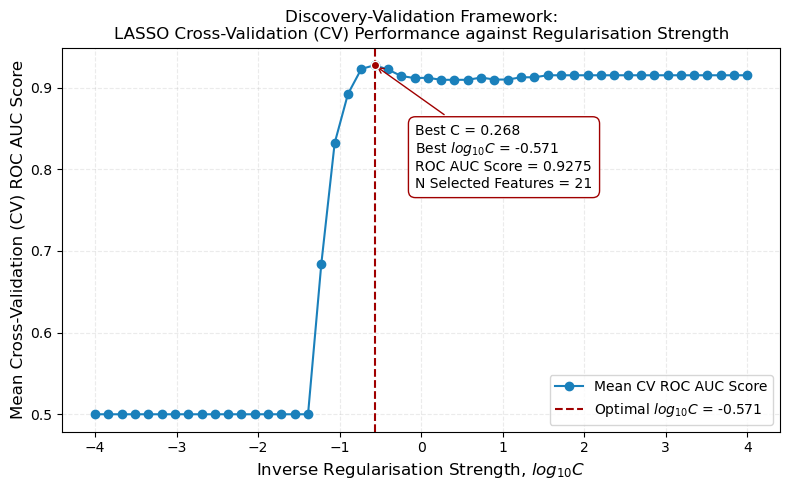

In [161]:
plt.figure(figsize=(8, 5))

# Plot the mean CV ROC AUC score against log10(C)
plt.plot(disval_lasso_logC_values, disval_lasso_mean_scores, marker='o', color='#1a80bb', label='Mean CV ROC AUC Score')

# Highlight the best C and its score
plt.axvline(np.log10(disval_lasso_bestC), color='#a00000', linestyle='--', label=f'Optimal $log_{{10}}C$ = {np.log10(disval_lasso_bestC):.3f}')
plt.scatter(np.log10(disval_lasso_bestC), disval_lasso_best_score, color='#a00000', edgecolor='white', zorder=5)

# Annotate best point
annot_text = (
    f'Best C = {disval_lasso_bestC:.3f}\n'
    f'Best $log_{{10}}C$ = {np.log10(disval_lasso_bestC):.3f}\n'
    f'ROC AUC Score = {disval_lasso_best_score:.4f}\n'
    f'N Selected Features = {n_disval_lasso_selected_features}'
)

plt.annotate(
    annot_text,
    xy=(np.log10(disval_lasso_bestC), disval_lasso_best_score),
    xytext=(np.log10(disval_lasso_bestC) + 0.5, disval_lasso_best_score - 0.15),
    arrowprops=dict(arrowstyle='->', color='#a00000', lw=1),
    bbox=dict(boxstyle='round, pad=0.5', fc='white', ec='#a00000'),
    fontsize=10
)

plt.xlabel('Inverse Regularisation Strength, $log_{10}C$', fontsize=12)
plt.ylabel('Mean Cross-Validation (CV) ROC AUC Score', fontsize=12)
plt.title('Discovery-Validation Framework:\nLASSO Cross-Validation (CV) Performance against Regularisation Strength', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.25)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()

### HSIC LASSO

#### Feature Matrix X and Label Vector y

In [100]:
# Create a DataFrame for training features with labels
df_mc_hsicLasso = X_train.copy()
df_mc_hsicLasso['Label'] = y_train.values
n_annota_metabo_features = df_mc_hsicLasso.shape[1] - 1  # subtract 1 for the label column

# Save to CSV
df_mc_hsicLasso.to_csv("Temp_Annota_Metabo_HSICLasso.csv", index=False)

In [101]:
# Initialise HSIC Lasso
disval_hsicLasso_model = HSICLasso()

# Fit the model and perform feature selection
disval_hsicLasso_model.input("Temp_Annota_Metabo_HSICLasso.csv", output_list=['Label'])
disval_hsicLasso_model.classification(num_feat=n_annota_metabo_features, B=10)

# Save the model to a pickle file
with open("disval_hsicLasso_model.pickle", "wb") as file:
    pickle.dump(disval_hsicLasso_model, file)

Block HSIC Lasso B = 10.
M set to 3.
Using Gaussian kernel for the features, Delta kernel for the outcomes.


c:\Users\chekj\anaconda3\envs\AI\Lib\site-packages\pyHSICLasso\api.py:107: RuntimeWarning: B 10 must be an exact divisor of the number of samples 88. Number of blocks 8.8 will be approximated to 8.
  warnings.warn(msg, RuntimeWarning)


#### Top Differentially Abundant Metabolites selected using HSIC LASSO

In [102]:
# Display results
disval_hsiclasso_selected_features = disval_hsicLasso_model.get_features()
print("Number of features selected:", len(disval_hsiclasso_selected_features),
      "\nSelected features:")
for i in range(len(disval_hsiclasso_selected_features)):
    print(disval_hsiclasso_selected_features[i])

Number of features selected: 25 
Selected features:
POS.2-AMINO-2-METHYLPROPANOIC ACID/4-AMINOBUTANOATE/DL-3-AMINOISOBUTANATE
NEG.Hypoxanthine early peak
NEG.L-ISOLEUCINE_FE 1.1975251
NEG.3-Methyl-2-oxobutyric acid
NEG.RESORCINOL MONOACETATE
NEG.D-GLUCONIC ACID*
POS.Propionyl-L-carnitine (C3:0)_FE
POS.ACar 5:0
POS.Cortisol_FE
NEG.Linoleic acid_FE
NEG.MYO-INOSITOL
POS.ACar 11:1
POS.Glycodeoxycholic acid_FE
NEG.4-HYDROXYBENZOATE
POS.trimethylamine N-oxide (TMAO)
NEG.Dihomo-gamma-linolenic acid (DGLA; cis-20:3n-6)
POS.Serotonin (-NH3)
NEG.HOMOVANILLIC ACID
POS.LPC 18:2/0:0_FE
NEG.Arachidonic acid
POS.LPC 20:3/0:0
POS.1-METHYLNICOTINAMIDE_FE minus a -H
POS.L-PIPECOLIC ACID_FE
POS.ACar 4:0_Isomer_1
NEG.3-METHYL-2-OXOVALERIC ACID


In [103]:
# Display the results of the HSIC Lasso model
disval_hsicLasso_model.dump()

============================================== HSICLasso : Result ==================================================
| Order | Feature      | Score | Top-5 Related Feature (Relatedness Score)                                          |
| 1     | POS.2-AMINO-2-METHYLPROPANOIC ACID/4-AMINOBUTANOATE/DL-3-AMINOISOBUTANATE | 1.000 | NEG.RESORCINOL MONOACETATE (0.302), POS.CORTICOSTERONE (0.301), POS.TRYPTOPHAN_FE (0.280), NEG.MYO-INOSITOL (0.280), NEG.L-TRYPTOPHAN_FE (0.279)|
| 2     | NEG.Hypoxanthine early peak | 0.604 | POS.Hypoxanthine early peak (0.967), NEG.HYPOXANTHINE_FE (0.907), POS.HYPOXANTHINE_FE (0.865), NEG.Inosine_FE (0.584), POS.Inosine_FE (0.582)|
| 3     | NEG.L-ISOLEUCINE_FE 1.1975251 | 0.564 | NEG.L-ISOLEUCINE_FE (0.812), POS.LEUCINE_FE (0.740), POS.L-ISOLEUCINE_FE/LEUCINE EARLY PEAK (0.709), POS.ISOLEUCINE_FE (0.594), NEG.L-VALINE_FE (0.568)|
| 4     | NEG.3-Methyl-2-oxobutyric acid | 0.492 | NEG.3-METHYL-2-OXOVALERIC ACID (0.311), POS.OXALOMALIC ACID* (0.298), POS.PC 36:

In [104]:
# Define a new function to replace the original save_param() method
def patched_save_param(self, filename='param.csv'):
    maxval = self.beta[self.A[0]][0]

    # Open the output file using the csv module to handle commas correctly
    with open(filename, 'w', newline='', encoding='utf-8') as fout:

        # Create a CSV writer with quoting to prevent issues with commas in feature names
        writer = csv.writer(fout, quoting=csv.QUOTE_MINIMAL)

        # Create and write the header row
        header = ['Feature', 'Score']
        for j in range(1, self.max_neighbors + 1):
            header += [f'Neighbor {j}', f'Neighbor {j} Score']
        writer.writerow(header)

        # Write one row per selected feature
        for i in range(len(self.A)):
            row = [
                self.featname[self.A[i]], # Feature name
                str(self.beta[self.A[i]][0] / maxval) # Normalised HSIC score
            ]

            # Add up to max_neighbors and their relatedness scores
            for j in range(1, self.max_neighbors + 1):
                row.append(self.featname[self.A_neighbors[i][j]])
                row.append(str(self.A_neighbors_score[i][j]))

            # Write the complete row to the CSV
            writer.writerow(row)

In [105]:
# Replace the existing save_param method of your HSICLasso model instance
disval_hsicLasso_model.save_param = types.MethodType(patched_save_param, disval_hsicLasso_model)

In [106]:
# Save the HSIC Lasso selected metabolites to a CSV file
disval_hsicLasso_model.save_param(filename="DisVal_HSICLasso_Selected_Annota_Metabolites.csv")

#### Find Optimal K Features

In [107]:
# Prepare outcome labels (y_train) and feature matrix
max_features = len(disval_hsiclasso_selected_features) 
k_range = range(1, max_features + 1)

In [108]:
# Evaluate roc auc for top k features
rocauc_scores = []

for k in k_range:
    selected_features = disval_hsiclasso_selected_features[:k]
    X_k = df_train[selected_features]

    # Fit logistic regression model and compute 5-fold CV roc auc scores
    clf = LogisticRegression(max_iter=10000, random_state=42)
    rocauc = cross_val_score(clf, X_k, y_train, cv=5, scoring='roc_auc').mean()
    rocauc_scores.append(rocauc)

In [109]:
# Find the best k based on ROC AUC
best_k = np.argmax(rocauc_scores) + 1
best_rocauc = rocauc_scores[best_k - 1]
best_features = disval_hsiclasso_selected_features[:best_k]

print(f"Best K: {best_k}")
print(f"Best ROC AUC score: {best_rocauc:.4f}")
print("Top selected features:")
for i, feature in enumerate(best_features, start=1):
    print(f"{i:>2}. {feature}")

Best K: 18
Best ROC AUC score: 0.9460
Top selected features:
 1. POS.2-AMINO-2-METHYLPROPANOIC ACID/4-AMINOBUTANOATE/DL-3-AMINOISOBUTANATE
 2. NEG.Hypoxanthine early peak
 3. NEG.L-ISOLEUCINE_FE 1.1975251
 4. NEG.3-Methyl-2-oxobutyric acid
 5. NEG.RESORCINOL MONOACETATE
 6. NEG.D-GLUCONIC ACID*
 7. POS.Propionyl-L-carnitine (C3:0)_FE
 8. POS.ACar 5:0
 9. POS.Cortisol_FE
10. NEG.Linoleic acid_FE
11. NEG.MYO-INOSITOL
12. POS.ACar 11:1
13. POS.Glycodeoxycholic acid_FE
14. NEG.4-HYDROXYBENZOATE
15. POS.trimethylamine N-oxide (TMAO)
16. NEG.Dihomo-gamma-linolenic acid (DGLA; cis-20:3n-6)
17. POS.Serotonin (-NH3)
18. NEG.HOMOVANILLIC ACID


In [110]:
# Load data
df_disval_Khsiclasso_selected_features = pd.read_csv("Disval_HSICLasso_Selected_Annota_Metabolites.csv")

In [111]:
# Save the optimal K metabolites to a CSV file
df_disval_Khsiclasso_selected_features.head(best_k).to_csv("Disval_HSICLasso_Selected_TopK_Annota_Metabolites.csv", index=False)

In [112]:
# Display the top K metabolites
display(df_disval_Khsiclasso_selected_features.head(best_k))

,Feature,Score,Neighbor 1,Neighbor 1 Score,Neighbor 2,Neighbor 2 Score,Neighbor 3,Neighbor 3 Score,Neighbor 4,Neighbor 4 Score,...,Neighbor 6,Neighbor 6 Score,Neighbor 7,Neighbor 7 Score,Neighbor 8,Neighbor 8 Score,Neighbor 9,Neighbor 9 Score,Neighbor 10,Neighbor 10 Score
0,POS.2-AMINO-2-METHYLPROPANOIC ACID/4-AMINOBUTA...,1.000000,NEG.RESORCINOL MONOACETATE,0.302481,POS.CORTICOSTERONE,0.300516,POS.TRYPTOPHAN_FE,0.280186,NEG.MYO-INOSITOL,0.279903,...,POS.TRYPTAMINE (-NH3),0.277283,POS.NICOTINAMIDE,0.275913,POS.Serotonin (-NH3),0.275482,NEG.L-PHENYLALANINE_FE,0.267824,POS.PC 34:3 Esi+8.373008,0.262438
1,NEG.Hypoxanthine early peak,0.603614,POS.Hypoxanthine early peak,0.966582,NEG.HYPOXANTHINE_FE,0.907362,POS.HYPOXANTHINE_FE,0.865262,NEG.Inosine_FE,0.584160,...,POS.Inosine_FE Esi+0.9530015,0.581881,NEG.INOSINE_FE,0.573590,NEG.Inosine_FE 0.95545524,0.562380,POS.INOSINE_FE,0.534754,NEG.(S)-LACTATE 1.0499887,0.355293
2,NEG.L-ISOLEUCINE_FE 1.1975251,0.563587,NEG.L-ISOLEUCINE_FE,0.811675,POS.LEUCINE_FE,0.740249,POS.L-ISOLEUCINE_FE/LEUCINE EARLY PEAK,0.708586,POS.ISOLEUCINE_FE,0.593974,...,POS.L-VALINE_FE,0.556309,POS.Piperidine_FE,0.534485,POS.TRYPTOPHAN_FE,0.448443,POS.TRYPTAMINE (-NH3),0.447702,NEG.L-TRYPTOPHAN_FE,0.447326
3,NEG.3-Methyl-2-oxobutyric acid,0.491813,NEG.3-METHYL-2-OXOVALERIC ACID,0.310817,POS.OXALOMALIC ACID*,0.298167,POS.PC 36:3,0.294934,NEG.ALPHA-HYDROXYISOBUTYRIC ACID,0.294298,...,NEG.L-TRYPTOPHAN_FE,0.286579,POS.ISOLEUCINE_FE,0.285805,POS.TRYPTOPHAN_FE,0.283849,NEG.LysoPE (18:2)_FE 6.8421044,0.282423,NEG.1-OLEOYL-RAC-GLYCEROL,0.282147
4,NEG.RESORCINOL MONOACETATE,0.489968,POS.1-METHYLNICOTINAMIDE_FE minus a -H,0.352142,POS.NICOTINAMIDE,0.317841,POS.2-AMINO-2-METHYLPROPANOIC ACID/4-AMINOBUTA...,0.302481,POS.CORTICOSTERONE,0.300895,...,POS.PC (36:4)_FE Esi+8.631991,0.255268,NEG.XANTHINE_FE,0.249526,NEG.L-Arabinose,0.249147,POS.PC 32:2,0.247946,POS.ACar 16:0,0.247858
5,NEG.D-GLUCONIC ACID*,0.367400,NEG.Threonic acid,0.294013,NEG.CITRIC ACID,0.265755,POS.1-METHYLNICOTINAMIDE_FE minus a -H,0.252116,NEG.LysoPC (14:0)_FE,0.245822,...,NEG.3-hydroxyisovaleric acid,0.228768,POS.LysoPC (16:0)_FE,0.226671,POS.LPC 16:3/0:0,0.226629,POS.LysoPC 14:0/0:0_FE,0.224824,POS.Plasmalogen PC(36:4) or PC(O-36:5)_FE,0.221522
6,POS.Propionyl-L-carnitine (C3:0)_FE,0.322567,POS.ACar 5:0,0.430483,POS.LysoPC 14:0/0:0_FE,0.394076,POS.LPC 16:3/0:0,0.388942,POS.LysoPC 14:0/0:0_FE_Isomer,0.380828,...,NEG.L-ISOLEUCINE_FE 1.1975251,0.372154,POS.LysoPE (16:1),0.369886,POS.ALANINE/SARCOSINE,0.354606,POS.ACar 4:0_Isomer_1,0.347687,NEG.LEUCINE_FE,0.336748
7,POS.ACar 5:0,0.276341,POS.Propionyl-L-carnitine (C3:0)_FE,0.430483,POS.L-METHIONINE_FE,0.353740,NEG.LEUCINE_FE,0.343938,POS.LEUCINE_FE,0.337200,...,NEG.LysoPE (20:4)_FE,0.320337,POS.LPC 20:4/0:0 Esi+7.0729985,0.318684,POS.L-ISOLEUCINE_FE/LEUCINE EARLY PEAK,0.318255,POS.L-PROLINE_FE,0.313715,NEG.L-ISOLEUCINE_FE 1.1975251,0.313147
8,POS.Cortisol_FE,0.262920,POS.CORTISOL_FE,0.981777,NEG.THEOPHYLLINE_FE,0.323108,POS.THEOPHYLLINE_FE,0.318017,NEG.MYO-INOSITOL,0.312480,...,POS.LPC 18:2/0:0_FE,0.286990,POS.LysoPC(20:2)_FE,0.286138,POS.L-METHIONINE_FE,0.280035,NEG.Dihomo-gamma-linolenic acid (DGLA; cis-20:...,0.277428,NEG.Linoleic acid_FE,0.276975
9,NEG.Linoleic acid_FE,0.221215,NEG.Oleic acid,0.857766,NEG.Dihomo-gamma-linolenic acid (DGLA; cis-20:...,0.634244,NEG.PALMITOLEIC ACID (cis-16:1n-7),0.598680,NEG.Arachidonic acid,0.480662,...,NEG.MYRISTIC ACID (14:0),0.435767,NEG.PALMITATE (16:0),0.394413,POS.LysoPC 14:0/0:0_FE_Isomer,0.378264,NEG.L-TRYPTOPHAN_FE,0.374319,POS.Docosahexaenoic acid_FE,0.370520


#### HSIC LASSO Performance Plot

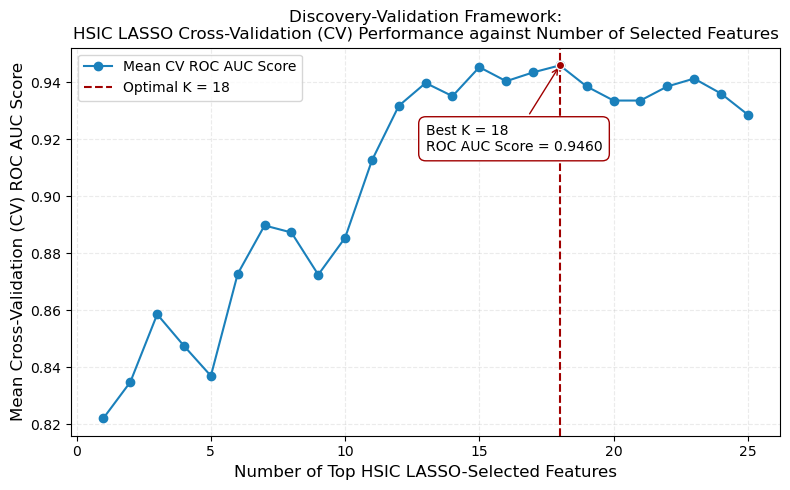

In [162]:
plt.figure(figsize=(8, 5))

# Plot the mean CV ROC AUC against number of selected features
plt.plot(k_range, rocauc_scores, marker='o', color='#1a80bb', label='Mean CV ROC AUC Score')

# Highlight the best k and its ROC AUC
plt.axvline(best_k, color='#a00000', linestyle='--', label=f'Optimal K = {best_k}')
plt.scatter(best_k, best_rocauc, color='#a00000', edgecolor='white', zorder=5)

# Annotate best point
annot_text = (
    f'Best K = {best_k}\n'
    f'ROC AUC Score = {best_rocauc:.4f}'
)

plt.annotate(
    annot_text,
    xy=(best_k, best_rocauc),
    xytext=(best_k - 5, best_rocauc - 0.03),
    arrowprops=dict(arrowstyle='->', color='#a00000', lw=1),
    bbox=dict(boxstyle='round, pad=0.5', fc='white', ec='#a00000'),
    fontsize=10
)

plt.title('Discovery-Validation Framework:\nHSIC LASSO Cross-Validation (CV) Performance against Number of Selected Features', fontsize=12)
plt.xlabel('Number of Top HSIC LASSO-Selected Features', fontsize=12)
plt.ylabel('Mean Cross-Validation (CV) ROC AUC Score', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.25)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

### LASSO and HSIC LASSO

In [114]:
# Load LASSO-selected metabolites
df_disval_lasso_selected = pd.read_csv("DisVal_LASSO_Selected_Annota_Metabolites.csv")
disval_lasso_selected_features = df_disval_lasso_selected['Metabolite'].tolist()

In [115]:
# Load HSIC LASSO-selected metabolites
df_disval_hsiclasso_selected = pd.read_csv("Disval_HSICLasso_Selected_TopK_Annota_Metabolites.csv")
disval_hsic_selected_features = df_disval_hsiclasso_selected['Feature'].tolist()

In [116]:
# Assume these are both lists of metabolite names
disval_lasso_selected = set(disval_lasso_selected_features)
disval_hsic_selected = set(disval_hsic_selected_features)

# Find the intersection
disval_intersected_features = list(disval_lasso_selected.intersection(disval_hsic_selected))

# Output
print(f"Number of intersected metabolites: {len(disval_intersected_features)}")
print("Intersected Metabolites:\n", disval_intersected_features)

Number of intersected metabolites: 11
Intersected Metabolites:
 ['POS.2-AMINO-2-METHYLPROPANOIC ACID/4-AMINOBUTANOATE/DL-3-AMINOISOBUTANATE', 'POS.Cortisol_FE', 'NEG.Linoleic acid_FE', 'POS.trimethylamine N-oxide (TMAO)', 'POS.Propionyl-L-carnitine (C3:0)_FE', 'POS.ACar 11:1', 'NEG.RESORCINOL MONOACETATE', 'NEG.MYO-INOSITOL', 'NEG.D-GLUCONIC ACID*', 'NEG.4-HYDROXYBENZOATE', 'NEG.HOMOVANILLIC ACID']


In [117]:
# Save the intersected metabolites to a pickle file
with open("disval_intersected_features.pickle", "wb") as file:
    pickle.dump(disval_intersected_features, file)

# Machine-Learning Based Approaches

## Import Libraries

In [118]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

## Logistic Regression (Baseline Model)

### Using LASSO-Selected Features

In [119]:
X_train_lasso = X_train[disval_lasso_selected_features]
X_test_lasso = X_test[disval_lasso_selected_features]

In [120]:
# Train Logistic Regression model using LASSO selected features
lasso_logReg_model = LogisticRegression(
    class_weight='balanced',
    solver='saga',
    penalty=None,  # No regularisation now, LASSO already selected features
    max_iter=10000,
    random_state=42
)
# Fit the model
lasso_logReg_model.fit(X_train_lasso, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, penalty=None,
                   random_state=42, solver='saga')

In [121]:
# Predict and evaluate
y_pred_lasso_lr = lasso_logReg_model.predict(X_test_lasso)
y_prob_lasso_lr = lasso_logReg_model.predict_proba(X_test_lasso)[:, 1]

print("Logistic Regression using LASSO-selected annotated metabolites\n")
print("Classification Report:\n", classification_report(y_test, y_pred_lasso_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lasso_lr))
print(f"\nROC AUC Score for Test Set: {roc_auc_score(y_test, y_prob_lasso_lr):.4f}")

Logistic Regression using LASSO-selected annotated metabolites

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87        25
           1       0.95      0.77      0.85        26

    accuracy                           0.86        51
   macro avg       0.88      0.86      0.86        51
weighted avg       0.88      0.86      0.86        51

Confusion Matrix:
 [[24  1]
 [ 6 20]]

ROC AUC Score for Test Set: 0.9231


#### StratifiedKFold Cross-Validation (CV)

In [122]:
# Conduct StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold CV
cv_scores = cross_val_score(lasso_logReg_model, X_train_lasso, y_train, cv=cv, scoring='roc_auc')

print(f"Logistic Regression using LASSO-selected annotated metabolites 5-Fold CV ROC AUC: {cv_scores.mean():.3f} \u00B1 {cv_scores.std():.3f}")

Logistic Regression using LASSO-selected annotated metabolites 5-Fold CV ROC AUC: 0.998 ± 0.005


### Using HSIC LASSO-Selected Features

In [123]:
X_train_hsic = X_train[disval_hsic_selected_features]
X_test_hsic = X_test[disval_hsic_selected_features]

In [125]:
# Train Logistic Regression model using HSIC LASSO selected features
hsic_logReg_model = LogisticRegression(
    class_weight='balanced',
    solver='saga',
    penalty=None,  # No regularisation now, HSIC LASSO already selected features
    max_iter=10000,
    random_state=42
)
# Fit the model
hsic_logReg_model.fit(X_train_hsic, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, penalty=None,
                   random_state=42, solver='saga')

In [126]:
# Predict and evaluate
y_pred_hsic_lr = hsic_logReg_model.predict(X_test_hsic)
y_prob_hsic_lr = hsic_logReg_model.predict_proba(X_test_hsic)[:, 1]

print("Logistic Regression using HSIC LASSO-selected annotated metabolites\n")
print("Classification Report:\n", classification_report(y_test, y_pred_hsic_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_hsic_lr))
print(f"\nROC AUC Score for Test Set: {roc_auc_score(y_test, y_prob_hsic_lr):.4f}")

Logistic Regression using HSIC LASSO-selected annotated metabolites

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        25
           1       1.00      0.88      0.94        26

    accuracy                           0.94        51
   macro avg       0.95      0.94      0.94        51
weighted avg       0.95      0.94      0.94        51

Confusion Matrix:
 [[25  0]
 [ 3 23]]

ROC AUC Score for Test Set: 0.9923


#### StratifiedKFold Cross-Validation (CV)

In [127]:
# Conduct StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold CV
cv_scores = cross_val_score(hsic_logReg_model, X_train_hsic, y_train, cv=cv, scoring='roc_auc')

print(f"Logistic Regression using HSIC LASSO-selected annotated metabolites 5-Fold CV ROC AUC: {cv_scores.mean():.3f} \u00B1 {cv_scores.std():.3f}")

Logistic Regression using HSIC LASSO-selected annotated metabolites 5-Fold CV ROC AUC: 0.944 ± 0.026


### Using LASSO-HSIC LASSO (Intersection) Selected Features

In [128]:
with open("disval_intersected_features.pickle", "rb") as file:
    disval_intersected_features = pickle.load(file)

In [129]:
X_train_intersect = X_train[disval_intersected_features]
X_test_intersect = X_test[disval_intersected_features]

In [ ]:
# Train Logistic Regression model using LASSO-HSIC LASSO selected features
intersect_logReg_model = LogisticRegression(
    class_weight='balanced',
    solver='saga',
    penalty=None,
    max_iter=10000,
    random_state=42
)
# Fit the model
intersect_logReg_model.fit(X_train_intersect, y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, penalty=None,
                   random_state=42, solver='saga')

In [131]:
# Predict and evaluate
y_pred_intersect= intersect_logReg_model.predict(X_test_intersect)
y_prob_intersect= intersect_logReg_model.predict_proba(X_test_intersect)[:, 1]

print("Logistic Regression using annotated metabolites from the intersection of LASSO and HSIC LASSO\n")
print("Classification Report:\n", classification_report(y_test, y_pred_intersect))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_intersect))
print(f"\nROC AUC Score for Test Set: {roc_auc_score(y_test, y_prob_intersect):.4f}")

Logistic Regression using annotated metabolites from the intersection of LASSO and HSIC LASSO

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92        25
           1       0.96      0.88      0.92        26

    accuracy                           0.92        51
   macro avg       0.92      0.92      0.92        51
weighted avg       0.92      0.92      0.92        51

Confusion Matrix:
 [[24  1]
 [ 3 23]]

ROC AUC Score for Test Set: 0.9631


#### StratifiedKFold Cross-Validation (CV)

In [132]:
# Conduct StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold CV
cv_scores = cross_val_score(intersect_logReg_model, X_train_intersect, y_train, cv=cv, scoring='roc_auc')

print(f"Logistic Regression using intersected annotated metabolites from LASSO and HSIC LASSO 5-Fold CV ROC AUC: {cv_scores.mean():.3f} \u00B1 {cv_scores.std():.3f}")

Logistic Regression using intersected annotated metabolites from LASSO and HSIC LASSO 5-Fold CV ROC AUC: 0.950 ± 0.025


## Random Forest

### Using LASSO-Selected Features

In [133]:
# Train Random Forest model using LASSO selected features
lasso_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',  # Adjusts weights inversely proportional to class frequency
    random_state=42
)
# Fit Random Forest model
lasso_rf_model.fit(X_train_lasso, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [134]:
# Predict and evaluate
y_pred_lasso_rf = lasso_rf_model.predict(X_test_lasso)
y_prob_lasso_rf = lasso_rf_model.predict_proba(X_test_lasso)[:, 1]

print("Random Forest using LASSO-selected features\n")
print("Classification Report:\n", classification_report(y_test, y_pred_lasso_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lasso_rf))
print(f"\nROC AUC Score for Test Set: {roc_auc_score(y_test, y_prob_lasso_rf):.4f}")

Random Forest using LASSO-selected features

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.88      0.80        25
           1       0.86      0.69      0.77        26

    accuracy                           0.78        51
   macro avg       0.80      0.79      0.78        51
weighted avg       0.80      0.78      0.78        51

Confusion Matrix:
 [[22  3]
 [ 8 18]]

ROC AUC Score for Test Set: 0.8969


#### StratifiedKFold Cross-Validation (CV)

In [135]:
# Conduct StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold CV
cv_scores = cross_val_score(lasso_rf_model, X_train_lasso, y_train, cv=cv, scoring='roc_auc')

print(f"Random Forest using LASSO-selected annotated metabolites 5-Fold CV ROC AUC: {cv_scores.mean():.3f} \u00B1 {cv_scores.std():.3f}")

Random Forest using LASSO-selected annotated metabolites 5-Fold CV ROC AUC: 0.992 ± 0.007


### Using HSIC LASSO-Selected Features

In [136]:
# Train Random Forest model using HSIC LASSO selected features
hsic_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',  # Adjusts weights inversely proportional to class frequency
    random_state=42
)
# Fit Random Forest model
hsic_rf_model.fit(X_train_hsic, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [137]:
# Predict and evaluate
y_pred_hsic_rf = hsic_rf_model.predict(X_test_hsic)
y_prob_hsic_rf = hsic_rf_model.predict_proba(X_test_hsic)[:, 1]

print("Random Forest using HSIC LASSO-selected annotated metabolites\n")
print("Classification Report:\n", classification_report(y_test, y_pred_hsic_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_hsic_rf))
print(f"\nROC AUC Score for Test Set: {roc_auc_score(y_test, y_prob_hsic_rf):.4f}")

Random Forest using HSIC LASSO-selected annotated metabolites

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.88      0.77        25
           1       0.84      0.62      0.71        26

    accuracy                           0.75        51
   macro avg       0.76      0.75      0.74        51
weighted avg       0.77      0.75      0.74        51

Confusion Matrix:
 [[22  3]
 [10 16]]

ROC AUC Score for Test Set: 0.9015


#### StratifiedKFold Cross-Validation (CV)

In [138]:
# Conduct StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold CV
cv_scores = cross_val_score(hsic_rf_model, X_train_hsic, y_train, cv=cv, scoring='roc_auc')

print(f"Random Forest using HSIC LASSO-selected annotated metabolites 5-Fold CV ROC AUC: {cv_scores.mean():.3f} \u00B1 {cv_scores.std():.3f}")

Random Forest using HSIC LASSO-selected annotated metabolites 5-Fold CV ROC AUC: 0.994 ± 0.011


### Using LASSO-HSIC LASSO (Intersection) Selected Features

In [139]:
# Train Random Forest model using intersected features
intersect_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight='balanced',  # Adjusts weights inversely proportional to class frequency
    random_state=42
)
# Fit Random Forest model
intersect_rf_model.fit(X_train_intersect, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [140]:
# Predict and evaluate
y_pred_intersect_rf = intersect_rf_model.predict(X_test_intersect)
y_prob_intersect_rf = intersect_rf_model.predict_proba(X_test_intersect)[:, 1]

print("Random Forest using annotated metabolites from the intersection of LASSO and HSIC LASSO\n")
print("Classification Report:\n", classification_report(y_test, y_pred_intersect_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_intersect_rf))
print(f"\nROC AUC Score for Test Set: {roc_auc_score(y_test, y_prob_intersect_rf):.4f}")

Random Forest using annotated metabolites from the intersection of LASSO and HSIC LASSO

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.88      0.79        25
           1       0.85      0.65      0.74        26

    accuracy                           0.76        51
   macro avg       0.78      0.77      0.76        51
weighted avg       0.78      0.76      0.76        51

Confusion Matrix:
 [[22  3]
 [ 9 17]]

ROC AUC Score for Test Set: 0.9092


#### StratifiedKFold Cross-Validation (CV)

In [141]:
# Conduct StratifiedKFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold CV
cv_scores = cross_val_score(intersect_rf_model, X_train_intersect, y_train, cv=cv, scoring='roc_auc')

print(f"Random Forest using annotated metabolites from the intersection of LASSO and HSIC LASSO 5-Fold CV ROC AUC: {cv_scores.mean():.3f} \u00B1 {cv_scores.std():.3f}")

Random Forest using annotated metabolites from the intersection of LASSO and HSIC LASSO 5-Fold CV ROC AUC: 0.989 ± 0.014


# Comparison of Feature Selection Methods

## Import Libraries

In [142]:
import matplotlib.pyplot as plt
import textwrap
import pandas as pd

## Metabolite Selection Across Feature Selection Methods

In [143]:
# Load feature names
uni_feats = set(pd.read_csv("Univariate_Significant_Metabo.csv")["Metabolite"])
lasso_feats = set(pd.read_csv("DisVal_LASSO_Selected_Annota_Metabolites.csv")["Metabolite"])
hsic_feats = set(pd.read_csv("DisVal_HSICLasso_Selected_Annota_Metabolites.csv")["Feature"])

In [144]:
# Combine all metabolites
all_feats = uni_feats | lasso_feats | hsic_feats

In [145]:
# Categorise by number of methods
only_1 = [f for f in all_feats if sum([f in uni_feats, f in lasso_feats, f in hsic_feats]) == 1]
only_2 = [f for f in all_feats if sum([f in uni_feats, f in lasso_feats, f in hsic_feats]) == 2]
all_3  = [f for f in all_feats if sum([f in uni_feats, f in lasso_feats, f in hsic_feats]) == 3]

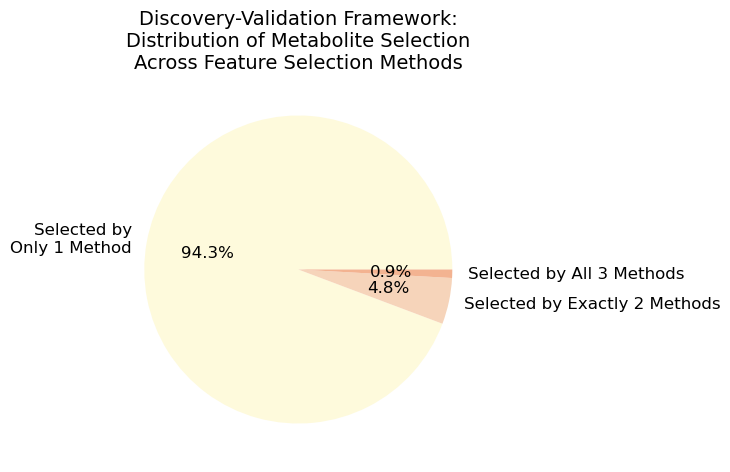

In [146]:
# Plot pie chart
labels = ['Selected by\nOnly 1 Method', 'Selected by Exactly 2 Methods', 'Selected by All 3 Methods']
sizes = [len(only_1), len(only_2), len(all_3)]
colors = ["#fefadc", "#f6d4ba", "#f3b391"]

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, textprops={'fontsize': 12})
plt.title('Discovery-Validation Framework:\nDistribution of Metabolite Selection\nAcross Feature Selection Methods', fontsize=14)
plt.show()

In [147]:
# Get feature importance from models
df_lasso_featImport = pd.DataFrame({
    "Metabolite": X_train_lasso.columns,
    "Importance": lasso_rf_model.feature_importances_,
    "in_lasso": True
})

df_hsic_featImport = pd.DataFrame({
    "Metabolite": X_train_hsic.columns,
    "Importance": hsic_rf_model.feature_importances_,
    "in_hsic": True
})

df_intersect_featImport = pd.DataFrame({
    "Metabolite": X_train_intersect.columns,
    "Importance": intersect_rf_model.feature_importances_,
    "in_intersect": True
})

In [148]:
# Merge all into one DataFrame
df_feature_importance = pd.concat([df_lasso_featImport, df_hsic_featImport, df_intersect_featImport], ignore_index=True)

# Group by metabolite and aggregate
df_feature_importance = df_feature_importance.groupby("Metabolite").agg({
    "Importance": "mean",
    "in_lasso": "max",
    "in_hsic": "max",
    "in_intersect": "max"
}).reset_index()

display(df_feature_importance)

,Metabolite,Importance,in_lasso,in_hsic,in_intersect
0,NEG.(S)-LACTATE 1.0499887,0.034635,True,NaN,NaN
1,NEG.3-HYDROXYANTHRANILIC ACID,0.018514,True,NaN,NaN
2,NEG.3-Methyl-2-oxobutyric acid,0.038705,NaN,True,NaN
3,NEG.3-hydroxyisovaleric acid,0.016400,True,NaN,NaN
4,NEG.4-HYDROXYBENZOATE,0.063051,True,True,True
5,NEG.D-GLUCONIC ACID*,0.088000,True,True,True
6,NEG.Dihomo-gamma-linolenic acid (DGLA; cis-20:...,0.025843,NaN,True,NaN
7,NEG.HOMOVANILLIC ACID,0.026171,True,True,True
8,NEG.Hypoxanthine early peak,0.116340,NaN,True,NaN
9,NEG.L-ARGININE,0.025209,True,NaN,NaN


In [149]:
# Estimate method_count
df_feature_importance["method_count"] = df_feature_importance[["in_lasso", "in_hsic", "in_intersect"]].sum(axis=1)

# Proportional split
df_feature_importance["lasso_part"] = df_feature_importance["Importance"] * df_feature_importance["in_lasso"] / df_feature_importance["method_count"]
df_feature_importance["hsic_part"] = df_feature_importance["Importance"] * df_feature_importance["in_hsic"] / df_feature_importance["method_count"]
df_feature_importance["intersect_part"] = df_feature_importance["Importance"] * df_feature_importance["in_intersect"] / df_feature_importance["method_count"]

df_feature_importance["lasso_part"] = df_feature_importance["lasso_part"].astype(float)
df_feature_importance["hsic_part"] = df_feature_importance["hsic_part"].astype(float)
df_feature_importance["intersect_part"] = df_feature_importance["intersect_part"].astype(float)

display(df_feature_importance)

,Metabolite,Importance,in_lasso,in_hsic,in_intersect,method_count,lasso_part,hsic_part,intersect_part
0,NEG.(S)-LACTATE 1.0499887,0.034635,True,NaN,NaN,1,0.034635,NaN,NaN
1,NEG.3-HYDROXYANTHRANILIC ACID,0.018514,True,NaN,NaN,1,0.018514,NaN,NaN
2,NEG.3-Methyl-2-oxobutyric acid,0.038705,NaN,True,NaN,1,NaN,0.038705,NaN
3,NEG.3-hydroxyisovaleric acid,0.016400,True,NaN,NaN,1,0.016400,NaN,NaN
4,NEG.4-HYDROXYBENZOATE,0.063051,True,True,True,3,0.021017,0.021017,0.021017
5,NEG.D-GLUCONIC ACID*,0.088000,True,True,True,3,0.029333,0.029333,0.029333
6,NEG.Dihomo-gamma-linolenic acid (DGLA; cis-20:...,0.025843,NaN,True,NaN,1,NaN,0.025843,NaN
7,NEG.HOMOVANILLIC ACID,0.026171,True,True,True,3,0.008724,0.008724,0.008724
8,NEG.Hypoxanthine early peak,0.116340,NaN,True,NaN,1,NaN,0.116340,NaN
9,NEG.L-ARGININE,0.025209,True,NaN,NaN,1,0.025209,NaN,NaN


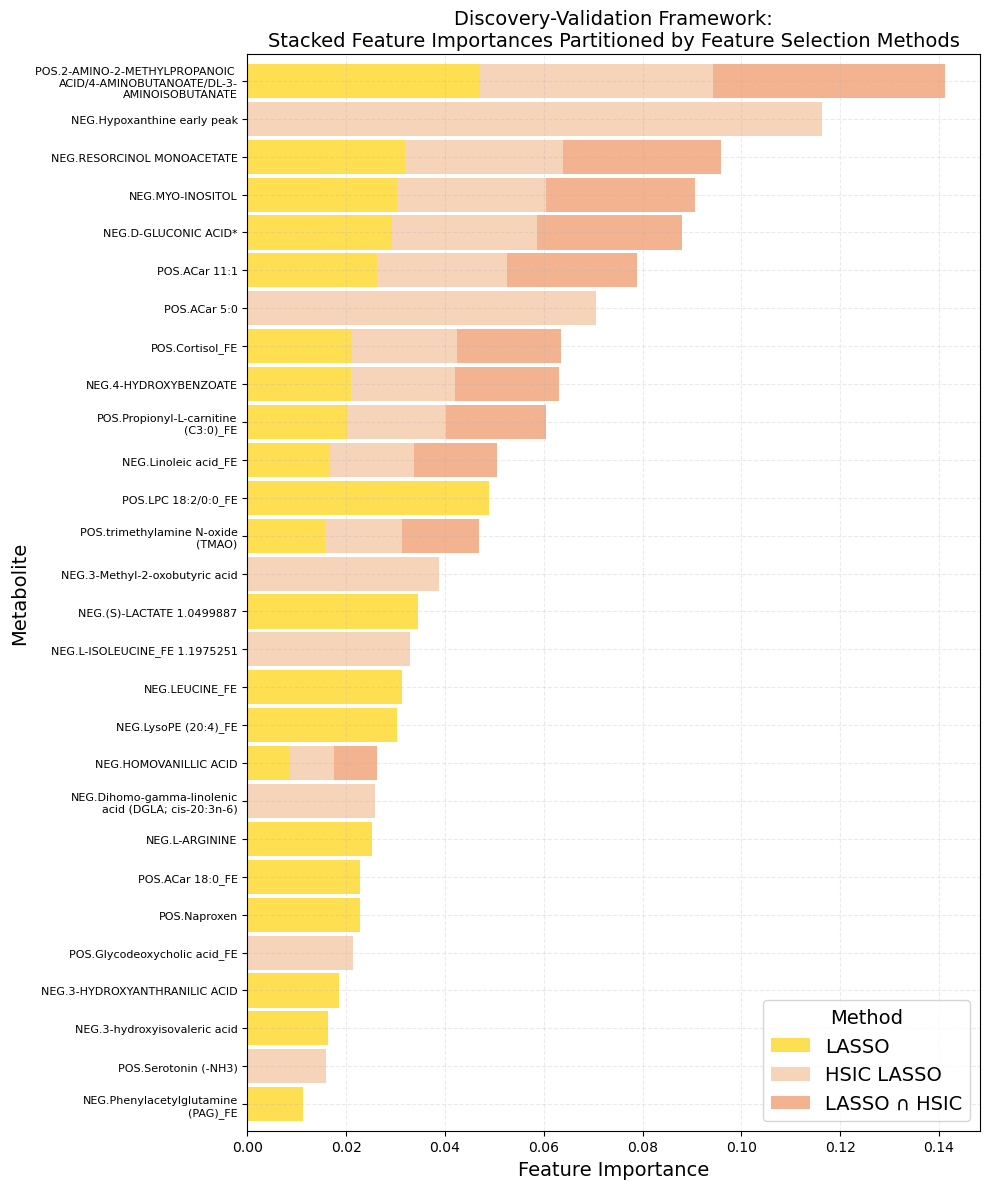

In [166]:
# Prepare for stacked bar
df_plot = df_feature_importance.set_index("Metabolite")[["lasso_part", "hsic_part", "intersect_part"]]
df_plot["Total_Importance"] = df_plot.sum(axis=1)
df_plot = df_plot.sort_values(by="Total_Importance", ascending=False).iloc[::-1]
df_plot = df_plot.drop(columns="Total_Importance")

# Wrap metabolite names (index) at 30 characters
df_plot.index = [ '\n'.join(textwrap.wrap(label, 30)) for label in df_plot.index]

# Plot
fig, ax = plt.subplots(figsize=(10, 12))

df_plot.plot(kind="barh", stacked=True, ax=ax,
             color=["#ffdf52", "#f6d4ba", "#f3b391"], width=0.9)

ax.set_title("Discovery-Validation Framework:\nStacked Feature Importances Partitioned by Feature Selection Methods", fontsize=14)
ax.tick_params(axis='y', labelsize=8)
ax.set_xlabel("Feature Importance", fontsize=14)
ax.set_ylabel("Metabolite", fontsize=14)
ax.legend(["LASSO", "HSIC LASSO", "LASSO \u2229 HSIC"], title="Method", fontsize=14, title_fontsize=14)
ax.grid(True, linestyle='--', alpha=0.25)

plt.tight_layout()
plt.show()

# Model Comparison

## Import Libraries

In [151]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import textwrap

## Feature Importance

In [152]:
# Utility to wrap long labels
def wrap_labels(labels, width=30):
    return ['\n'.join(textwrap.wrap(label, width)) for label in labels]

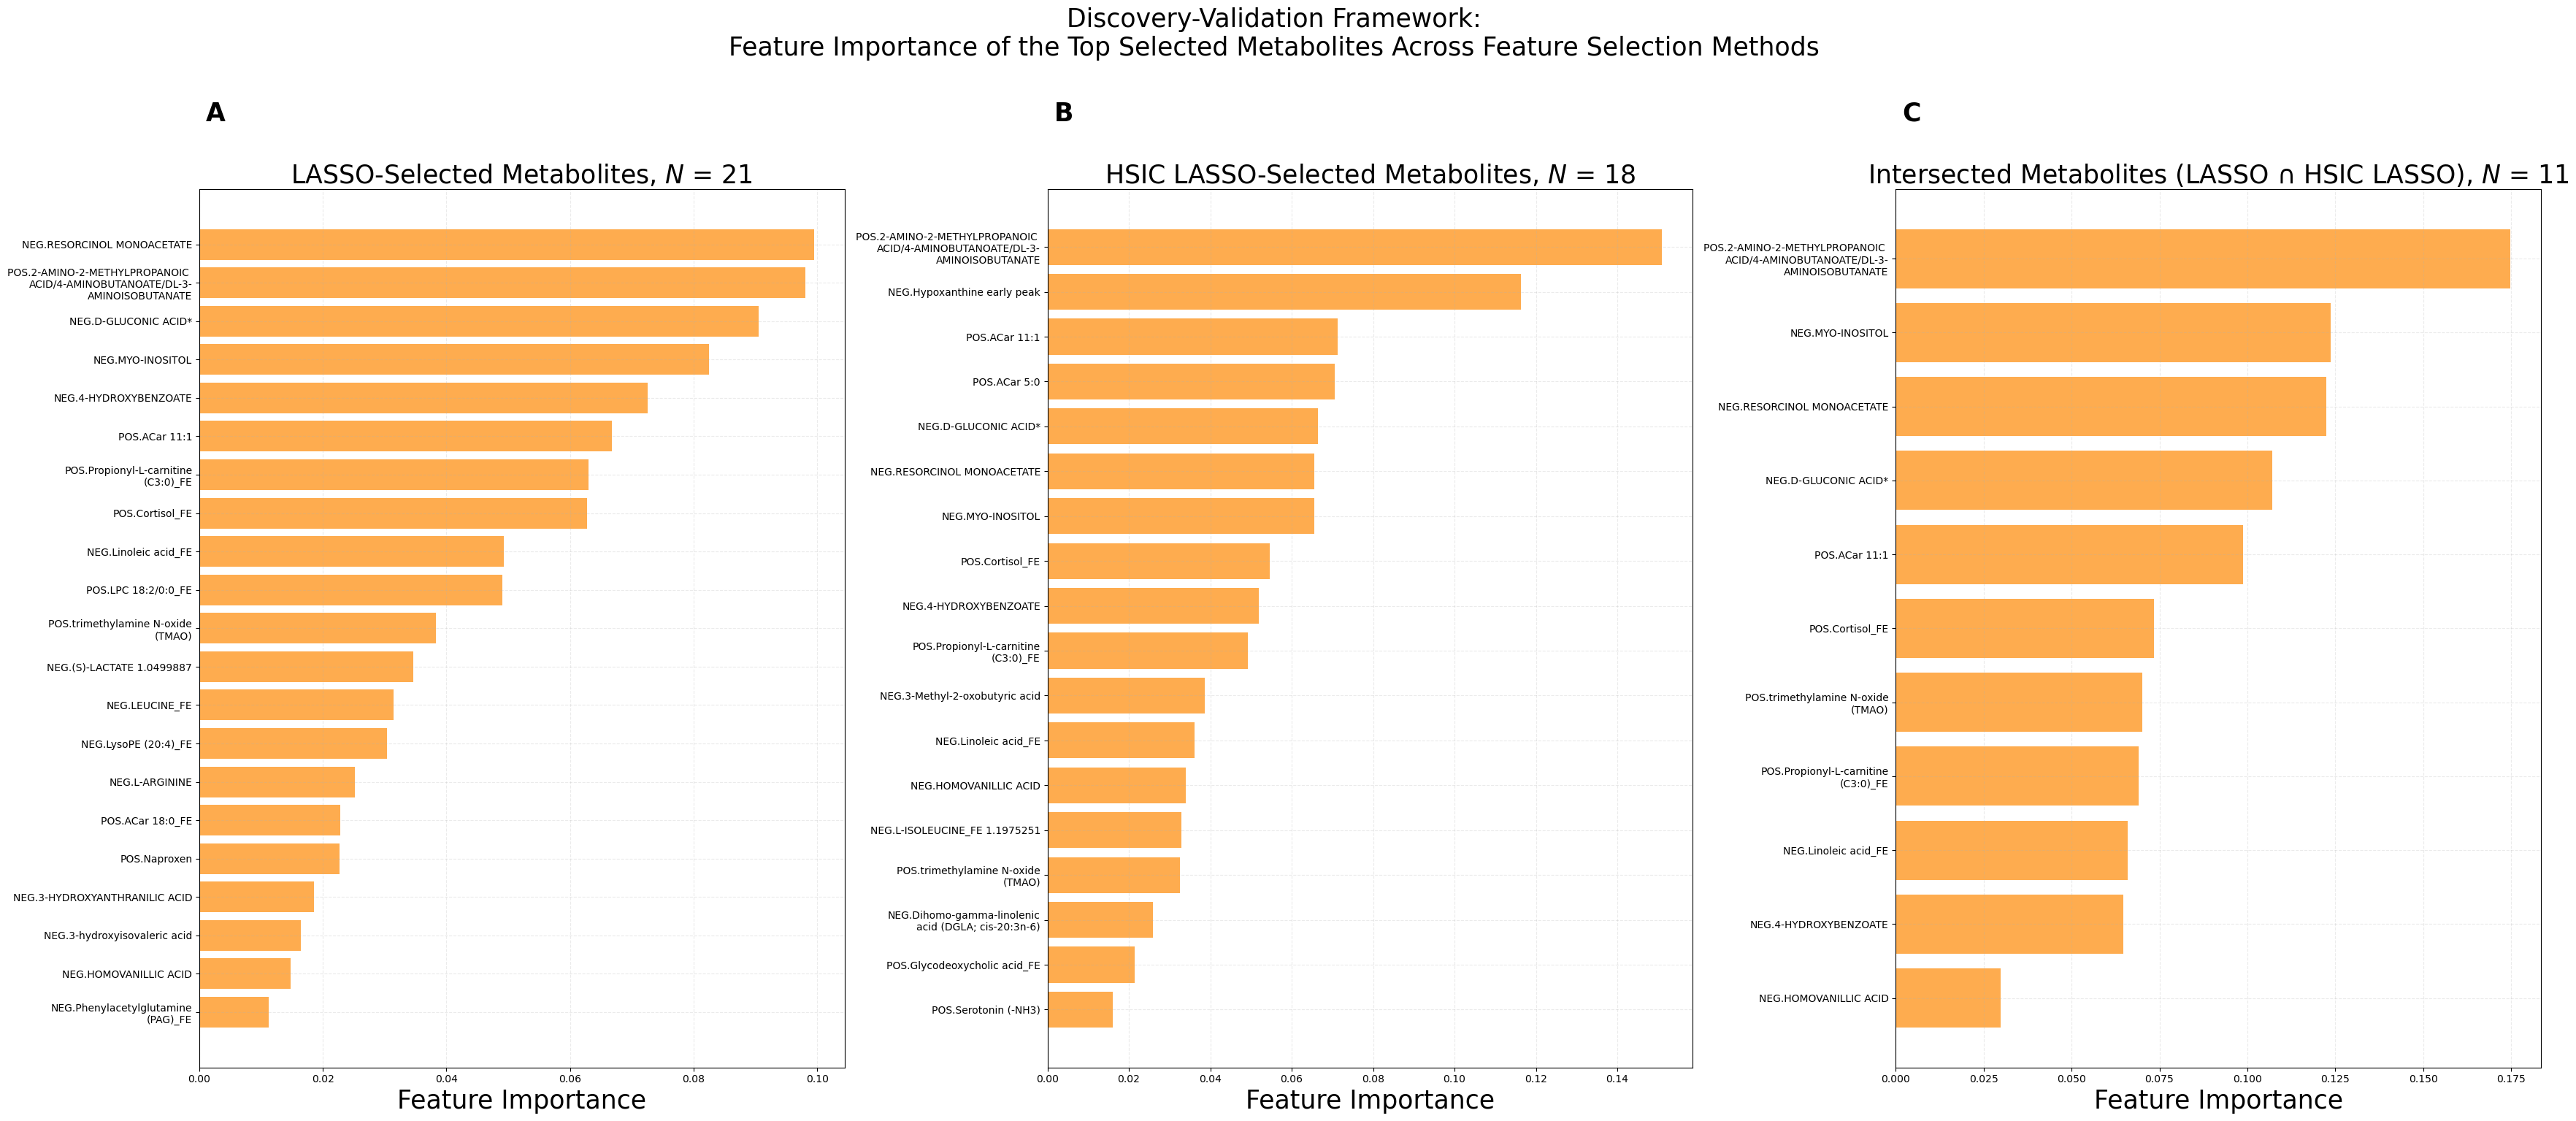

In [174]:
fig, ax = plt.subplots(1, 3, figsize=(35, 15))

# Plot LASSO
importances = lasso_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = X_train_lasso.columns[indices]
wrapped_labels = wrap_labels(features_sorted[::-1])

ax[0].barh(range(len(importances)), importances[indices][::-1], color='#FEAC4F')
ax[0].set_yticks(range(len(wrapped_labels)))
ax[0].set_yticklabels(wrapped_labels, fontsize=10)
ax[0].set_xlabel("Feature Importance", fontsize=25)
ax[0].set_title(f"LASSO-Selected Metabolites, $N$ = {len(importances)}", fontsize=25)
ax[0].grid(True, linestyle='--', alpha=0.25)
ax[0].text(0.01, 1.1, 'A', transform=ax[0].transAxes, fontsize=25, fontweight='bold', va='top')

# Plot HSIC Lasso
importances = hsic_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = X_train_hsic.columns[indices]
wrapped_labels = wrap_labels(features_sorted[::-1])

ax[1].barh(range(len(importances)), importances[indices][::-1], color='#FEAC4F')
ax[1].set_yticks(range(len(wrapped_labels)))
ax[1].set_yticklabels(wrapped_labels, fontsize=10)
ax[1].set_xlabel("Feature Importance", fontsize=25)
ax[1].set_title(f"HSIC LASSO-Selected Metabolites, $N$ = {len(importances)}", fontsize=25)
ax[1].grid(True, linestyle='--', alpha=0.25)
ax[1].text(0.01, 1.1, 'B', transform=ax[1].transAxes, fontsize=25, fontweight='bold', va='top')

# Plot intersected
importances = intersect_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = X_train_intersect.columns[indices]
wrapped_labels = wrap_labels(features_sorted[::-1])

ax[2].barh(range(len(importances)), importances[indices][::-1], color='#FEAC4F')
ax[2].set_yticks(range(len(wrapped_labels)))
ax[2].set_yticklabels(wrapped_labels, fontsize=10)
ax[2].set_xlabel("Feature Importance", fontsize=25)
ax[2].set_title(f"Intersected Metabolites (LASSO ∩ HSIC LASSO), $N$ = {len(importances)}", fontsize=25)
ax[2].grid(True, linestyle='--', alpha=0.25)
ax[2].text(0.01, 1.1, 'C', transform=ax[2].transAxes, fontsize=25, fontweight='bold', va='top')

plt.suptitle("Discovery-Validation Framework:\nFeature Importance of the Top Selected Metabolites Across Feature Selection Methods", fontsize=25, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## Confusion Matrices

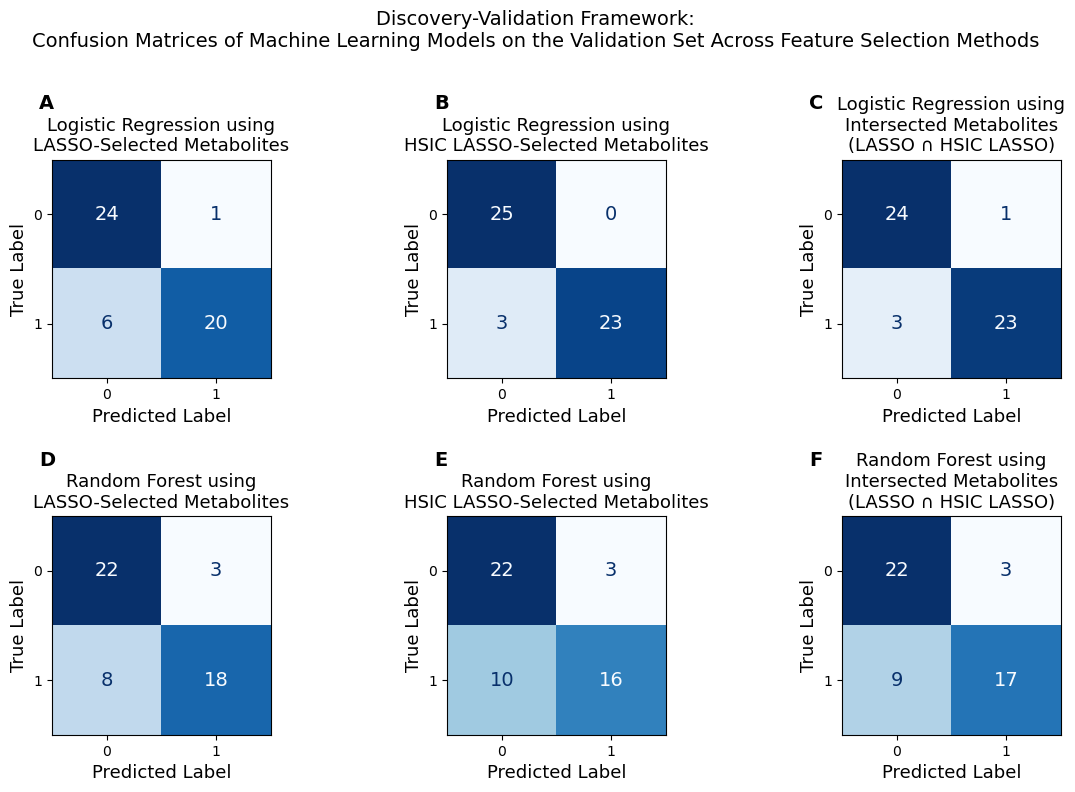

In [154]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ConfusionMatrixDisplay.from_estimator(lasso_logReg_model, X_test_lasso, y_test, cmap='Blues', ax=ax[0,0], colorbar=False)
ax[0,0].set_title("Logistic Regression using\nLASSO-Selected Metabolites", fontsize=13)
ax[0,0].set_xlabel("Predicted Label", fontsize=13)
ax[0,0].set_ylabel("True Label", fontsize=13)
ax[0,0].text(-0.06, 1.3, 'A', transform=ax[0,0].transAxes, fontsize=13, fontweight='bold', va='top')

ConfusionMatrixDisplay.from_estimator(hsic_logReg_model, X_test_hsic, y_test, cmap='Blues', ax=ax[0,1], colorbar=False)
ax[0,1].set_title("Logistic Regression using\nHSIC LASSO-Selected Metabolites", fontsize=13)
ax[0,1].set_xlabel("Predicted Label", fontsize=13)
ax[0,1].set_ylabel("True Label", fontsize=13)
ax[0,1].text(-0.06, 1.3, 'B', transform=ax[0,1].transAxes, fontsize=13, fontweight='bold', va='top')

ConfusionMatrixDisplay.from_estimator(intersect_logReg_model, X_test_intersect, y_test, cmap='Blues', ax=ax[0,2], colorbar=False)
ax[0,2].set_title("Logistic Regression using\nIntersected Metabolites\n(LASSO \u2229 HSIC LASSO)", fontsize=13)
ax[0,2].set_xlabel("Predicted Label", fontsize=13)
ax[0,2].set_ylabel("True Label", fontsize=13)
ax[0,2].text(-0.15, 1.3, 'C', transform=ax[0,2].transAxes, fontsize=13, fontweight='bold', va='top')

ConfusionMatrixDisplay.from_estimator(lasso_rf_model, X_test_lasso, y_test, cmap='Blues', ax=ax[1,0], colorbar=False)
ax[1,0].set_title("Random Forest using\nLASSO-Selected Metabolites", fontsize=13)
ax[1,0].set_xlabel("Predicted Label", fontsize=13)
ax[1,0].set_ylabel("True Label", fontsize=13)
ax[1,0].text(-0.06, 1.3, 'D', transform=ax[1,0].transAxes, fontsize=13, fontweight='bold', va='top')

ConfusionMatrixDisplay.from_estimator(hsic_rf_model, X_test_hsic, y_test, cmap='Blues', ax=ax[1,1], colorbar=False)
ax[1,1].set_title("Random Forest using\nHSIC LASSO-Selected Metabolites", fontsize=13)
ax[1,1].set_xlabel("Predicted Label", fontsize=13)
ax[1,1].set_ylabel("True Label", fontsize=13)
ax[1,1].text(-0.06, 1.3, 'E', transform=ax[1,1].transAxes, fontsize=13, fontweight='bold', va='top')

ConfusionMatrixDisplay.from_estimator(intersect_rf_model, X_test_intersect, y_test, cmap='Blues', ax=ax[1,2], colorbar=False)
ax[1,2].set_title("Random Forest using\nIntersected Metabolites\n(LASSO \u2229 HSIC LASSO)", fontsize=13)
ax[1,2].set_xlabel("Predicted Label", fontsize=13)
ax[1,2].set_ylabel("True Label", fontsize=13)
ax[1,2].text(-0.15, 1.3, 'F', transform=ax[1,2].transAxes, fontsize=13, fontweight='bold', va='top')

# Set font size of the cell values inside all confusion matrices
for row in ax:
    for a in row:
        for text in a.texts:
            text.set_fontsize(14)

plt.suptitle("Discovery-Validation Framework:\nConfusion Matrices of Machine Learning Models on the Validation Set Across Feature Selection Methods", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Receiver Operating Characteristic (ROC) Curves

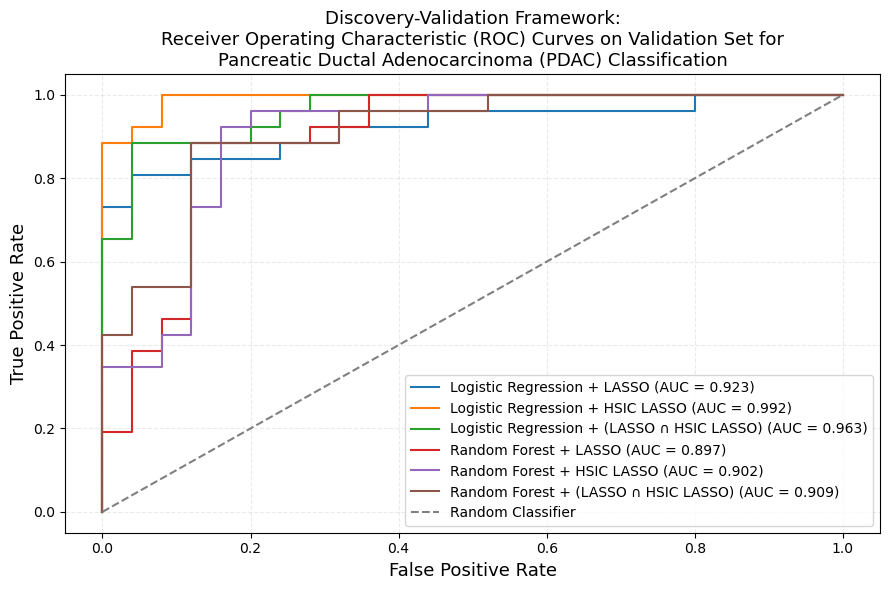

In [160]:
plt.figure(figsize=(9, 6))

# Logistic Regression (LASSO)
y_prob_lasso_lg = lasso_logReg_model.predict_proba(X_test_lasso)[:, 1]
fpr_lasso_lg, tpr_lasso_lg, _ = roc_curve(y_test, y_prob_lasso_lg)
auc_lasso_lg = auc(fpr_lasso_lg, tpr_lasso_lg)
plt.plot(fpr_lasso_lg, tpr_lasso_lg, label=f"Logistic Regression + LASSO (AUC = {auc_lasso_lg:.3f})")

# Logistic Regression (HSIC)
y_prob_hsic_lg = hsic_logReg_model.predict_proba(X_test_hsic)[:, 1]
fpr_hsic_lg, tpr_hsic_lg, _ = roc_curve(y_test, y_prob_hsic_lg)
auc_hsic_lg = auc(fpr_hsic_lg, tpr_hsic_lg)
plt.plot(fpr_hsic_lg, tpr_hsic_lg, label=f"Logistic Regression + HSIC LASSO (AUC = {auc_hsic_lg:.3f})")

# Logistic Regression (LASSO-HSIC)
y_prob_intersect_lg = intersect_logReg_model.predict_proba(X_test_intersect)[:, 1]
fpr_intersect_lg, tpr_intersect_lg, _ = roc_curve(y_test, y_prob_intersect_lg)
auc_intersect_lg = auc(fpr_intersect_lg, tpr_intersect_lg)
plt.plot(fpr_intersect_lg, tpr_intersect_lg, label=f"Logistic Regression + (LASSO \u2229 HSIC LASSO) (AUC = {auc_intersect_lg:.3f})")

# Random Forest (LASSO)
y_prob_lasso_rf = lasso_rf_model.predict_proba(X_test_lasso)[:, 1]
fpr_lasso_rf, tpr_lasso_rf, _ = roc_curve(y_test, y_prob_lasso_rf)
auc_lasso_rf = auc(fpr_lasso_rf, tpr_lasso_rf)
plt.plot(fpr_lasso_rf, tpr_lasso_rf, label=f"Random Forest + LASSO (AUC = {auc_lasso_rf:.3f})")

# Random Forest (HSIC)
y_prob_hsic_rf = hsic_rf_model.predict_proba(X_test_hsic)[:, 1]
fpr_hsic_rf, tpr_hsic_rf, _ = roc_curve(y_test, y_prob_hsic_rf)
auc_hsic_rf = auc(fpr_hsic_rf, tpr_hsic_rf)
plt.plot(fpr_hsic_rf, tpr_hsic_rf, label=f"Random Forest + HSIC LASSO (AUC = {auc_hsic_rf:.3f})")

# Random Forest (LASSO-HSIC)
y_prob_intersect_rf = intersect_rf_model.predict_proba(X_test_intersect)[:, 1]
fpr_intersect_rf, tpr_intersect_rf, _ = roc_curve(y_test, y_prob_intersect_rf)
auc_intersect_rf = auc(fpr_intersect_rf, tpr_intersect_rf)
plt.plot(fpr_intersect_rf, tpr_intersect_rf, label=f"Random Forest + (LASSO \u2229 HSIC LASSO) (AUC = {auc_intersect_rf:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel("False Positive Rate", fontsize=13)
plt.ylabel("True Positive Rate", fontsize=13)
plt.title("Discovery-Validation Framework:\nReceiver Operating Characteristic (ROC) Curves on Validation Set for\nPancreatic Ductal Adenocarcinoma (PDAC) Classification", fontsize=13)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.25)
plt.tight_layout()
plt.show()